In [1]:
import torch
from torch import nn, optim
import numpy as np
import torchvision
from torchvision import datasets,models,transforms
import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion()

In [7]:
data_transforms={
    'train':transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
data_dir = 'hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


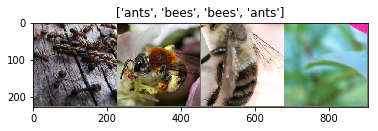

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.show()

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [18]:
def train_model(model,criterion, optimizer, scheduler,num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-'*10)
        
        for phase in ['train','val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _,preds = torch.max(outputs,1)
                    loss = criterion(outputs,labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time()-since
    print(f'training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val acc: {best_acc:4f}')
    
    model.load_state_dict(best_model_wts)
    return model


In [25]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs,labels) in enumerate(dataloaders['val']):
            outputs = model(inputs)
            _,preds = torch.max(outputs,1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2,2,images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [22]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs,2)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(),lr=0.001,momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft,step_size=7,gamma=0.1)


In [23]:
model_ft = train_model(model_ft,criterion,optimizer_ft,exp_lr_scheduler,num_epochs=2)

Epoch 0/1
----------
train Loss: 0.5612 Acc: 0.7131
val Loss: 0.4150 Acc: 0.8170

Epoch 1/1
----------
train Loss: 0.5344 Acc: 0.7746
val Loss: 0.5152 Acc: 0.8431

training complete in 1m 43s
Best val acc: 0.843137


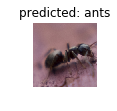

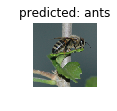

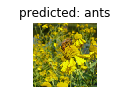

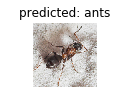

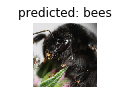

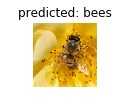

In [26]:
visualize_model(model_ft)

In [27]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs,2)

criterion=nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(),lr=0.001,momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv,step_size=7,gamma=0.1)


In [30]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.4837 Acc: 0.7746
val Loss: 0.3293 Acc: 0.8627

Epoch 1/9
----------
train Loss: 0.5646 Acc: 0.7664
val Loss: 0.2529 Acc: 0.9085

Epoch 2/9
----------
train Loss: 0.4695 Acc: 0.8115
val Loss: 0.1522 Acc: 0.9477

Epoch 3/9
----------
train Loss: 0.4096 Acc: 0.8320
val Loss: 0.1801 Acc: 0.9477

Epoch 4/9
----------
train Loss: 0.2908 Acc: 0.8852
val Loss: 0.1850 Acc: 0.9281

Epoch 5/9
----------
train Loss: 0.3424 Acc: 0.8566
val Loss: 0.2251 Acc: 0.9150

Epoch 6/9
----------
train Loss: 0.3271 Acc: 0.8770
val Loss: 0.1647 Acc: 0.9477

Epoch 7/9
----------
train Loss: 0.4034 Acc: 0.8033
val Loss: 0.1774 Acc: 0.9477

Epoch 8/9
----------
train Loss: 0.3442 Acc: 0.8770
val Loss: 0.1739 Acc: 0.9412

Epoch 9/9
----------
train Loss: 0.2931 Acc: 0.8607
val Loss: 0.1820 Acc: 0.9412

training complete in 3m 59s
Best val acc: 0.947712


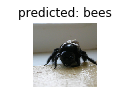

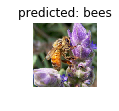

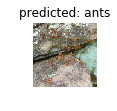

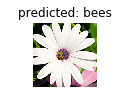

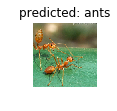

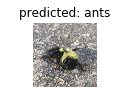

In [31]:
visualize_model(model_conv)

plt.ioff()
plt.show()